In [1]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns = {'GDP (current US$)':'GDP'}, inplace = True )
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


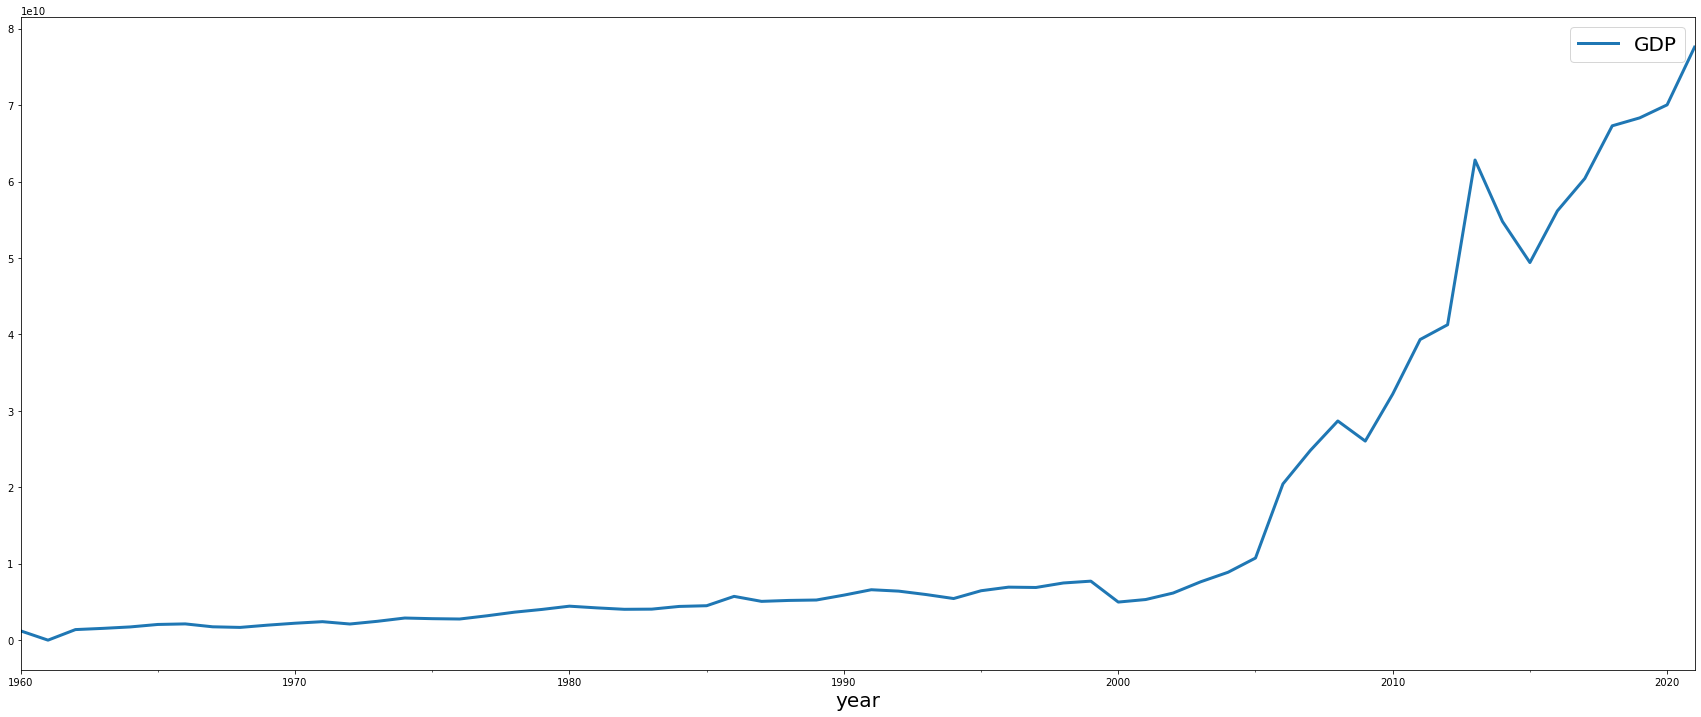

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [4]:
data.asfreq(freq='AS') #Convert time series to specified frequency.

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [5]:
data.isna().sum()

GDP    0
dtype: int64

In [6]:
data[data['GDP']==0]

,GDP
year,
1961-01-01,0.0


In [7]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)

In [8]:
data.GDP = data['GDP'].interpolate(method='linear')

In [9]:
train_df = data.loc[:"2019-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((60, 1), (3, 1))

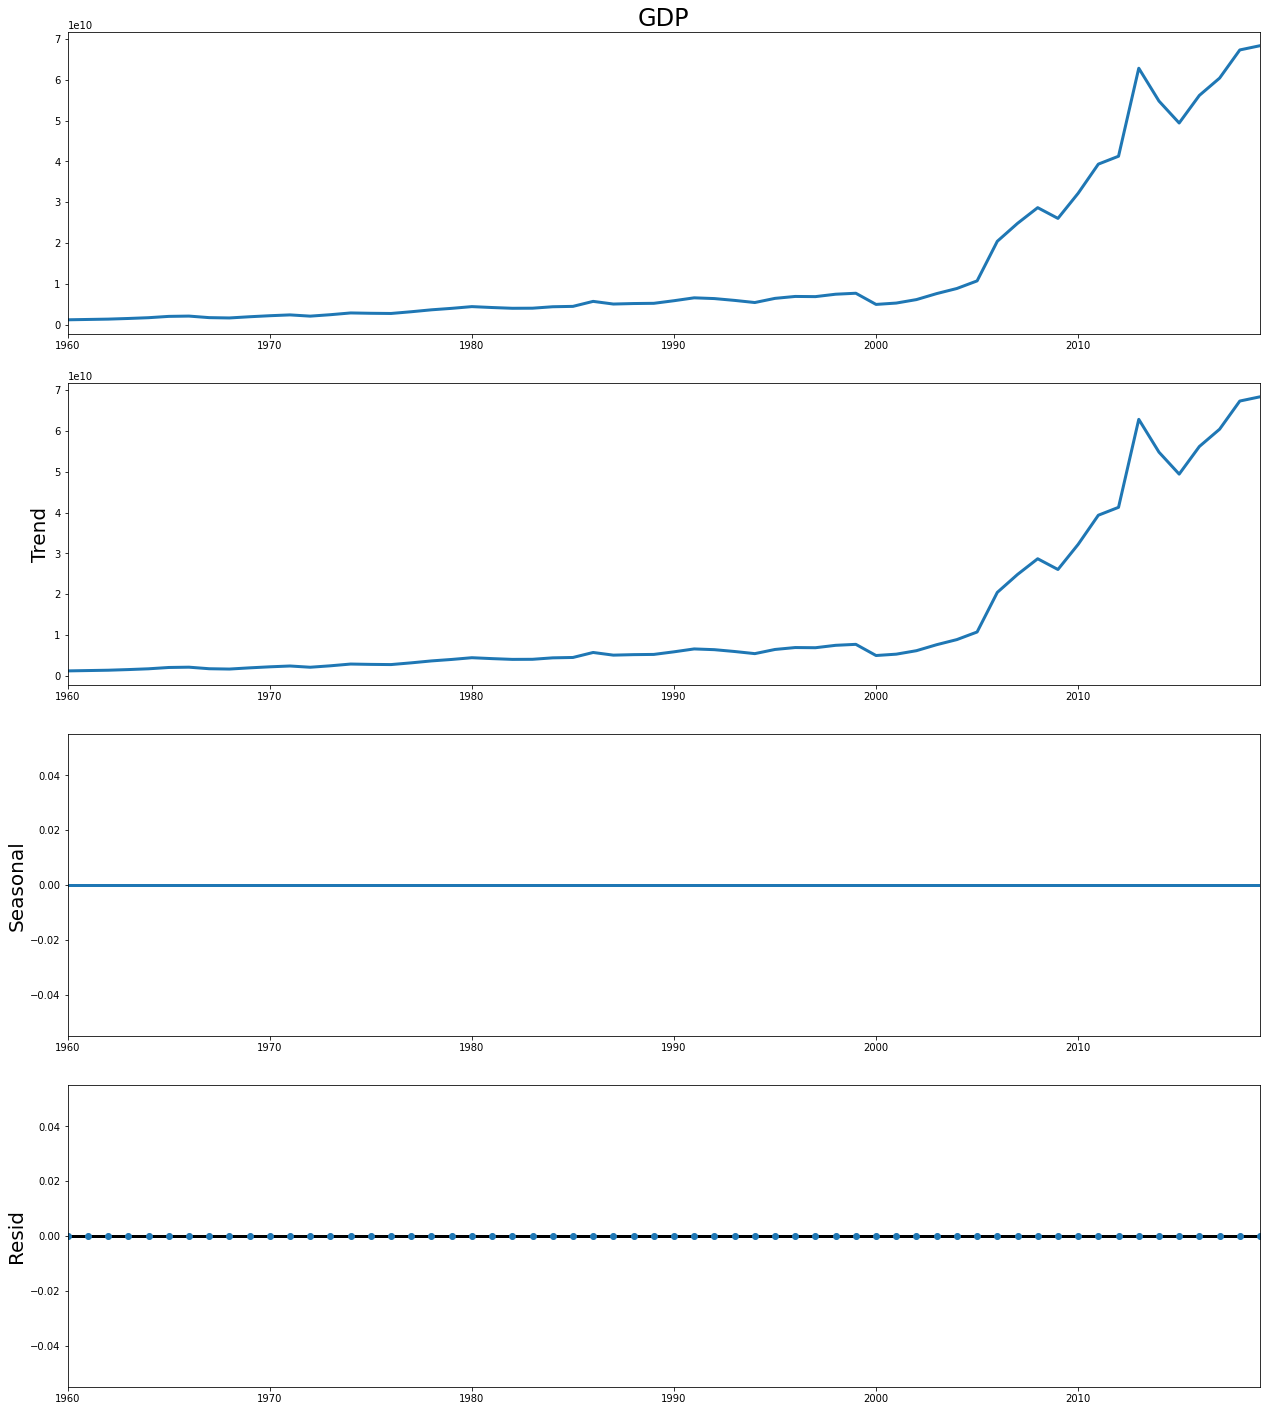

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.GDP)
result.plot()
plt.show()

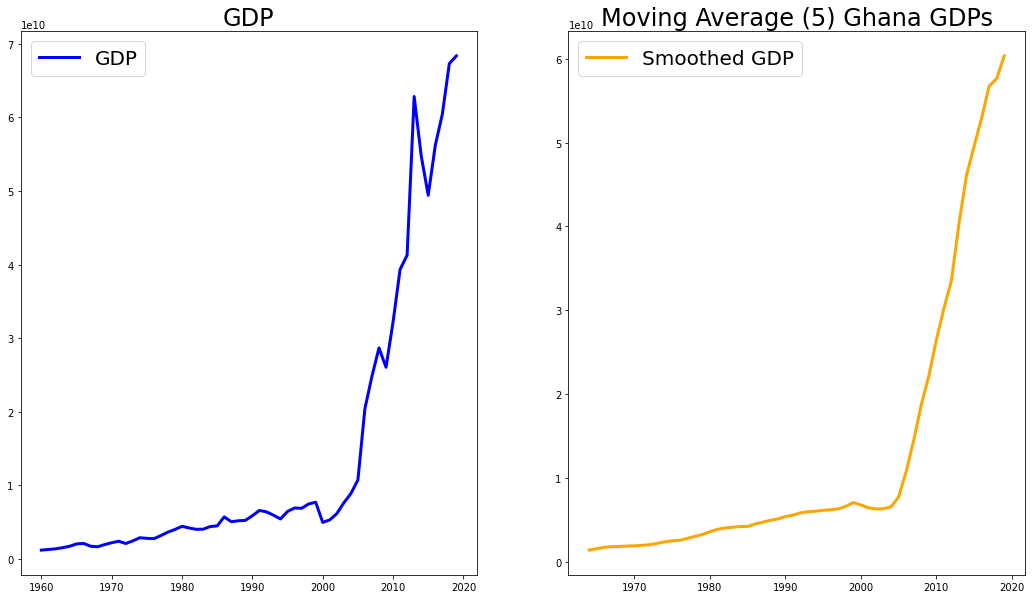

In [11]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(1,2)

# Окно в месяц (Window = 2)
ax[0].plot(train_df.GDP, color="blue", label="GDP")
ax[0].set_title("GDP", size=24)
ax[0].legend()

ax[1].plot(
    train_df.GDP.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1].set_title("Moving Average (5) Ghana GDPs", size=24)
ax[1].legend()


plt.show()

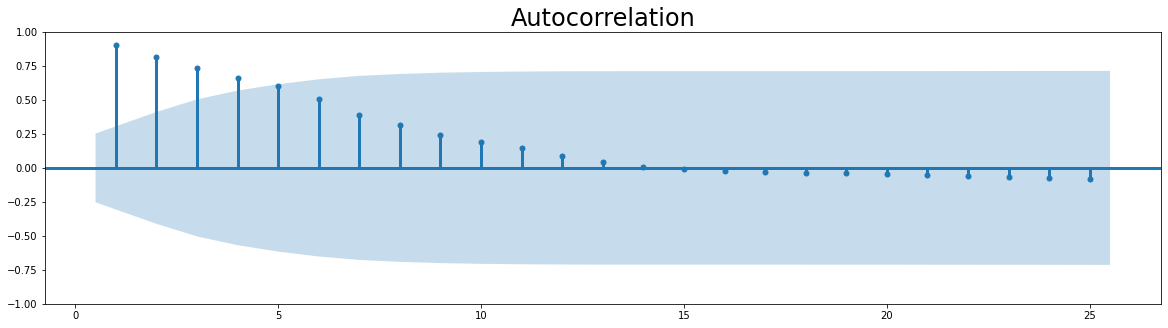

In [12]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.GDP, lags=25, zero=False)
plt.show()

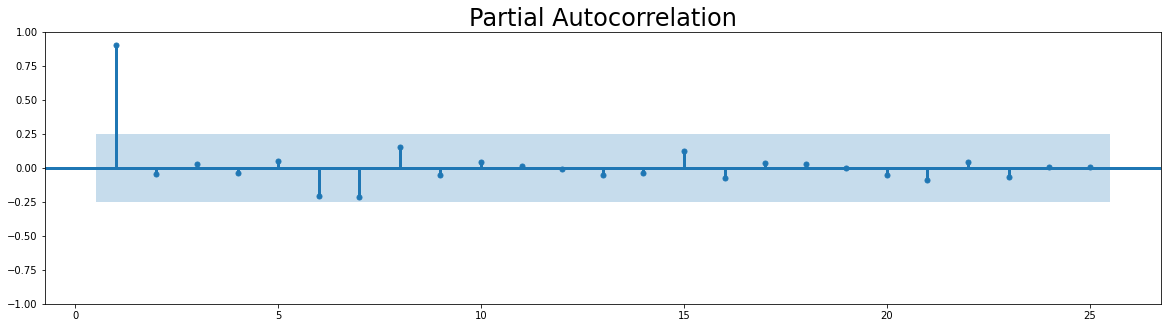

In [13]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.GDP, lags=25, method="ywm", zero=False)
plt.show()

In [14]:
test1 = adfuller(train_df["GDP"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.5601921925450473
p-value:  0.9865922097956231
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому GDP Ганы не являются стационарными

In [15]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=len(series)/2 - 2)
    sgt.plot_pacf(series, ax=axes[1], lags=len(series)/2 - 2, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

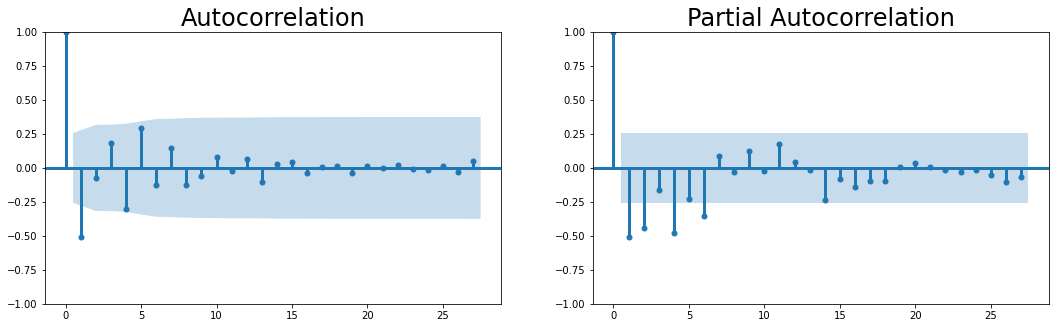

(-2.8736041436160886,
 0.04850470474849169,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2148.198472386424)

In [16]:
diff_1 = train_df["GDP"].diff().dropna()
plot_acf_pacf(diff_1.diff().dropna())
adfuller(diff_1.diff().dropna())

Вторые разности являются стационарными

## ARIMA, SARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP"].dropna(), order=(2, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Администратор.000\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Администратор.000\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Администратор.000\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   60
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1360.960
Date:                Sat, 29 Jul 2023   AIC                           2729.919
Time:                        19:52:32   BIC                           2738.161
Sample:                    01-01-1960   HQIC                          2733.130
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2569      0.224     -1.149      0.251      -0.695       0.181
ar.L2         -0.2203      0.283     -0.778      0.437      -0.775       0.335
ma.L1         -0.8248      0.122     -6.767      0.000      -1.064      -0.586
sigma2      1.819e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               364.08
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             491.00   Skew:                             1.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.72e+55. Standard errors may be unstable.
"""

In [18]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

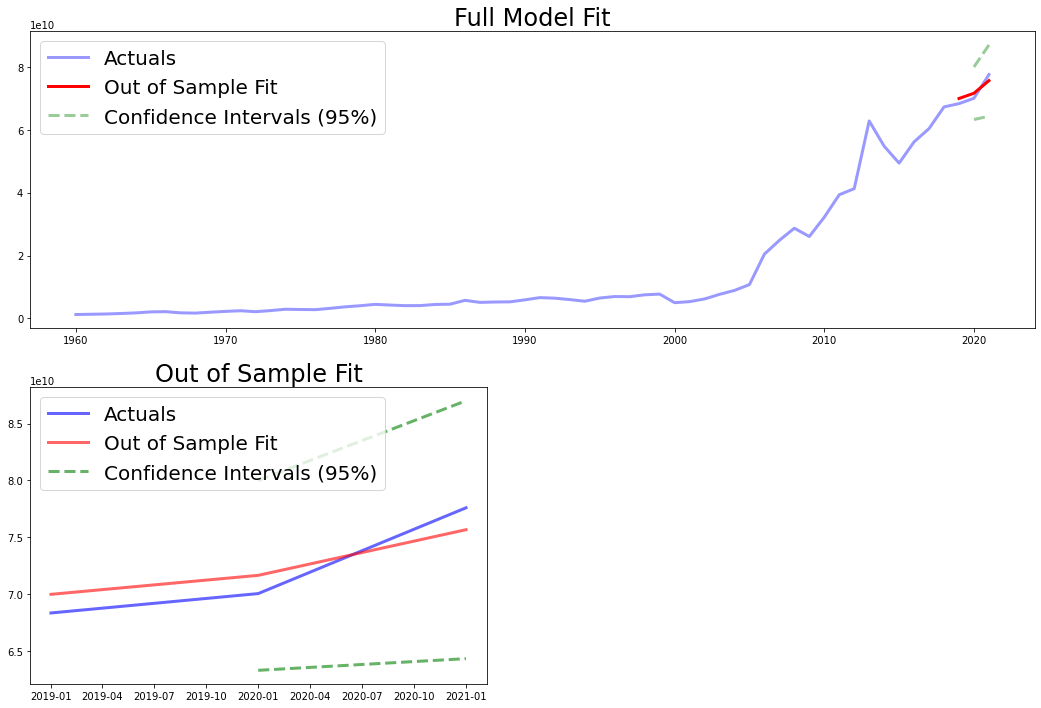

In [19]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [20]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=6,
    max_q=6,
    D=2,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,2,1)[5]             : AIC=2308.925, Time=0.07 sec
 ARIMA(0,2,0)(0,2,0)[5]             : AIC=2354.597, Time=0.01 sec
 ARIMA(1,2,0)(1,2,0)[5]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,1)(0,2,1)[5]             : AIC=2314.029, Time=0.05 sec
 ARIMA(1,2,1)(0,2,0)[5]             : AIC=2317.682, Time=0.04 sec
 ARIMA(1,2,1)(1,2,1)[5]             : AIC=2307.203, Time=0.10 sec
 ARIMA(1,2,1)(1,2,0)[5]             : AIC=2311.270, Time=0.27 sec
 ARIMA(1,2,1)(2,2,1)[5]             : AIC=2305.334, Time=0.31 sec
 ARIMA(1,2,1)(2,2,0)[5]             : AIC=inf, Time=nan sec
 ARIMA(1,2,1)(2,2,2)[5]             : AIC=2307.330, Time=0.53 sec
 ARIMA(1,2,1)(1,2,2)[5]             : AIC=2307.663, Time=0.13 sec
 ARIMA(0,2,1)(2,2,1)[5]             : AIC=2311.116, Time=0.28 sec
 ARIMA(1,2,0)(2,2,1)[5]             : AIC=2310.374, Time=0.27 sec
 ARIMA(2,2,1)(2,2,1)[5]             : AIC=2285.523, Time=0.37 sec
 ARIMA(2,2,1)(1,2,1)[5]             : AIC=22

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(2, 2, 0)x(2, 2, [1], 5)   Log Likelihood               -1136.243
Date:                             Sat, 29 Jul 2023   AIC                           2284.486
Time:                                     19:52:42   BIC                           2295.713
Sample:                                 01-01-1960   HQIC                          2288.729
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8332      0.205     -4.056      0.000      -1.236      -0.431
ar.L2         -0.5380      0.217     -2.481      0.013      -0.963      -0.113
ar.S.L5       -0.9835      0.758     -1.298      0.194      -2.469       0.502
ar.S.L10      -1.0000      0.984     -1.016      0.309      -2.928       0.928
ma.S.L5       -0.5130      0.695     -0.738      0.460      -1.874       0.848
sigma2      3.671e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                43.88
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):              95.41   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.37e+56. Standard errors may be unstable.
"""

### Валидация временных рядов

In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=7) # max_train_size=df.sales.count()-7
#tscv = TimeSeriesSplit(n_splits=3)

In [22]:
train_test_groups = tscv.split(data.GDP) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


### Волатильность

In [23]:
data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

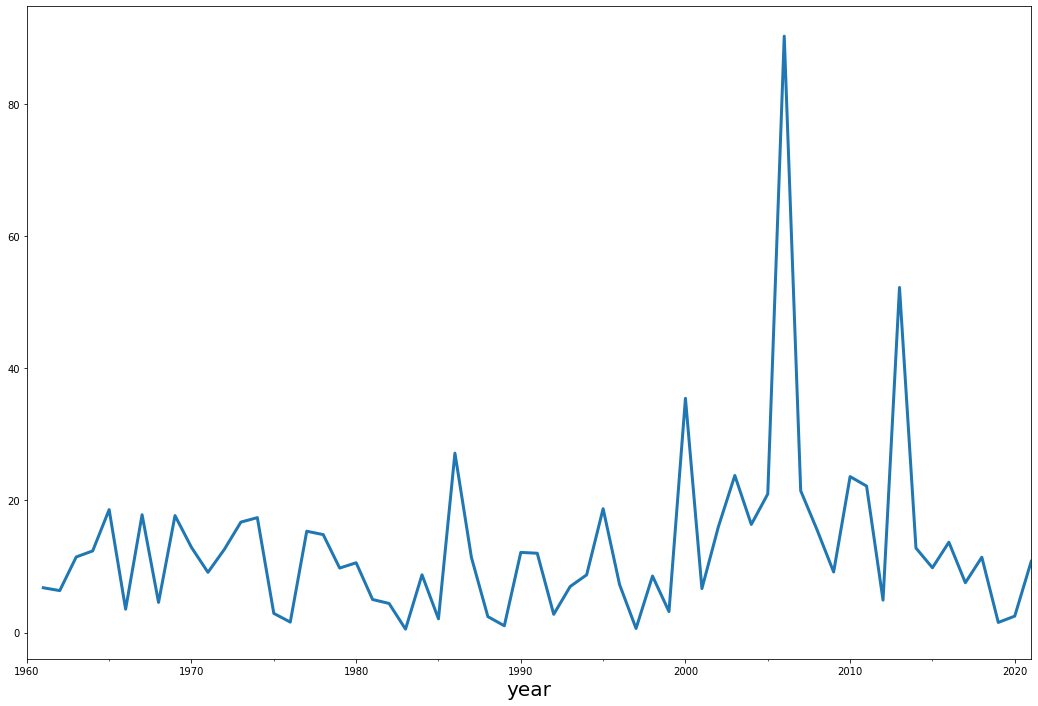

In [24]:
data["GDP_vol"].plot()
plt.show()

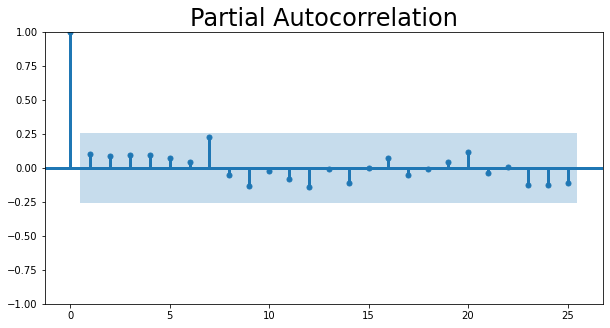

In [25]:
train_df = data.loc[:"2019-01-01"]
test_df = data.loc["2019-01-01":]
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.GDP_vol[1:], lags=25, method="ywm")
plt.show()

In [26]:
adfuller(train_df.GDP_vol[1:])

(-6.726503409724899,
 3.379140565297867e-09,
 0,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 390.63418032580034)

In [39]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])

In [28]:
from arch import arch_model

model = arch_model(garch_df["GDP_vol"].dropna(), p=10, q=10)
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:    120,   Neg. LLF: 222.52313213165942
Iteration:     10,   Func. Count:    240,   Neg. LLF: 214.25229443880232
Iteration:     15,   Func. Count:    355,   Neg. LLF: 213.90581884755449
Iteration:     20,   Func. Count:    471,   Neg. LLF: 213.08491485631174
Iteration:     25,   Func. Count:    586,   Neg. LLF: 213.07944778422032
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.07944778422032
            Iterations: 25
            Function evaluations: 586
            Gradient evaluations: 25


In [29]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.079
Distribution:                  Normal   AIC:                           470.159
Method:            Maximum Likelihood   BIC:                           515.489
                                        No. Observations:                   58
Date:                Sat, Jul 29 2023   Df Residuals:                       57
Time:                        19:52:43   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.3062      1.192      9.486  2.400e-21 [  8.970, 13.642]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         27.3972     29.010      0.944      0.345      [-29.462, 84.257]
alpha[1]       0.0000  9.838e-03      0.000      1.000 [-1.928e-02,1.928e-02]
alpha[2]       0.0000  1.926e-02      0.000      1.000 [-3.775e-02,3.775e-02]
alpha[3]       0.0000  4.422e-02      0.000      1.000 [-8.668e-02,8.668e-02]
alpha[4]   3.5855e-03  5.501e-03      0.652      0.515 [-7.197e-03,1.437e-02]
alpha[5]       0.0000  1.993e-02      0.000      1.000 [-3.905e-02,3.905e-02]
alpha[6]       0.7161  2.184e-02     32.781 1.086e-235      [  0.673,  0.759]
alpha[7]       0.0832      0.355      0.234      0.815      [ -0.612,  0.779]
alpha[8]       0.0000      0.324      0.000      1.000      [ -0.635,  0.635]
alpha[9]       0.0000      0.213      0.000      1.000      [ -0.417,  0.417]
alpha[10]      0.0000      0.403      0.000      1.000      [ -0.789,  0.789]
beta[1]        0.0000      0.536      0.000      1.000      [ -1.051,  1.051]
beta[2]        0.0000      0.465      0.000      1.000      [ -0.911,  0.911]
beta[3]        0.0000      0.338      0.000      1.000      [ -0.662,  0.662]
beta[4]        0.0000      0.572      0.000      1.000      [ -1.120,  1.120]
beta[5]        0.0000  9.561e-02      0.000      1.000      [ -0.187,  0.187]
beta[6]        0.0000  2.165e-02      0.000      1.000 [-4.242e-02,4.242e-02]
beta[7]        0.0000      0.259      0.000      1.000      [ -0.508,  0.508]
beta[8]        0.1971      0.249      0.792      0.429      [ -0.291,  0.685]
beta[9]        0.0000      0.316      0.000      1.000      [ -0.620,  0.620]
beta[10]       0.0000      0.923      0.000      1.000      [ -1.810,  1.810]
=============================================================================

Covariance estimator: robust
"""

In [30]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index] #.residual_variance — прогнозируемая условная дисперсия остатков
predictions_df.head(3)

,GDP,GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,1056.935877
2020-01-01,7.004320e+10,2.495937,154.712368
2021-01-01,7.759428e+10,10.780603,59.519808


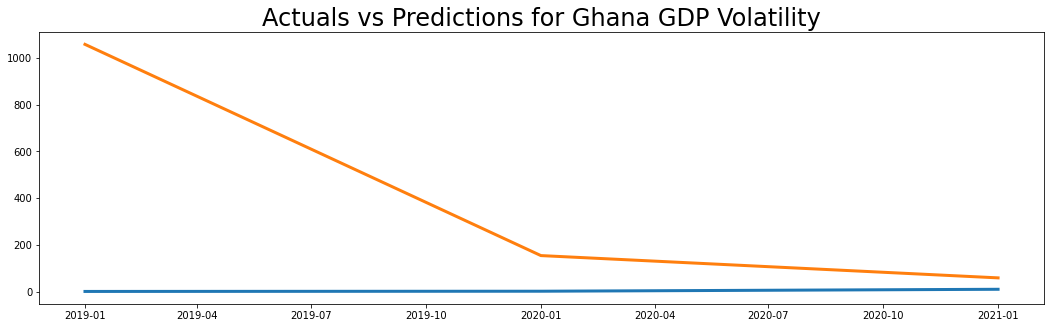

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for Ghana GDP Volatility", size=24)

plt.show()

In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])

379800.0043530946

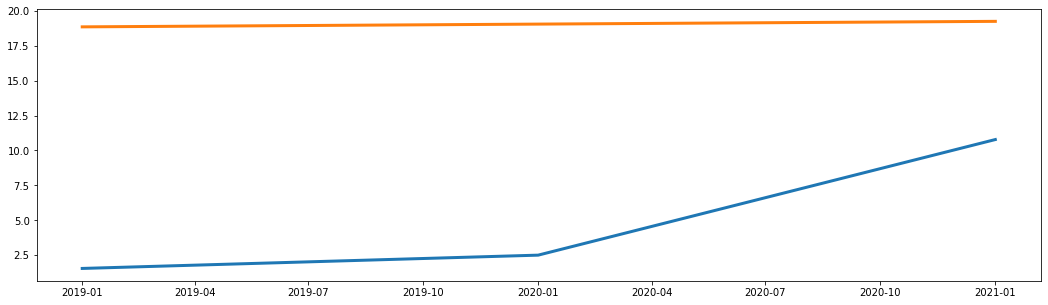

In [50]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["GDP_vol"].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data["GDP_vol"].shape[0]))[train_df.shape[0]-1:].fillna(0)

y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()